# Spam-Ham Filter
#### Screening Task 5

**Objective:** Using the provided data set, come up with an algorithm, coded in Python to categorize the forum posts as spam or not spam.

This document describes the analysis done on the provided dataset in detail.

__Author__: Ashutosh Gangwar &lt;ashutoshgngwr@gmail.com&gt;

In [1]:
import pandas
dataset = pandas.read_excel('./Data Set.xlsx', 'Data set')
dataset.sample(frac=0.01)

,Data,Label
530,"If I am interpreting your question correctly, ...",Not Spam
77,"Hi,<div><br></div><div>While installing eSim s...",Not Spam
130,"<p style=""margin-bottom: 0px;"">es) (part ac))<...",Not Spam
129,"Dear Ankush,<br><br>Please make sure the sourc...",Not Spam
216,NaN,NaN
277,Please look at the following links-\n\nhttps:/...,Not Spam
648,"Hello Sir,<br>The screencast taken by kazam is...",Not Spam
286,We will delete this question. We will have to ...,Not Spam
406,"Hi leohpaz, can you provide the values of k(i)...",Not Spam


## Cleaning the dataset

On visually inspecting the given dataset, one can spot following _irrelavant features_
* HTML Tags in datapoints
* Datapoints that only contain HTML Tags without any valid content
* Empty and/or NaN cells/rows

To remove HTML tags, regular expressions can be utilized. Further more, links in `<a>` & `<img>` tags can be preserved to be utilized as features in classification of spams and hams. 

We also exploit this iteration by replacing Labels for each datapoint with corresponding integer values (0 for Ham, 1 for Spam).

To remove rows with empty cells, all `''` are replaced with `NaN`'s value from `numpy` and then `dataframe`'s `dropna()` function is used to remove all `NaN`s altogether.

In [2]:
import re
import numpy as np

rgx_img_anch_tags = re.compile('(<a href|<img src)=(\"|\')(.*?)(\"|\').*?>')
rgx_other_html_tags = re.compile('<.*?>')

for i in range(0, dataset.shape[0]):
    if dataset.Data[i] is np.nan:
        continue # no need to process null values.
        
    dataset.Data[i] = str(dataset.Data[i])
    # replace a & img tags with their URL
    dataset.Data[i] = rgx_img_anch_tags.sub(r' \3 ', dataset.Data[i])
    # remove all remaining html tags
    dataset.Data[i] = rgx_other_html_tags.sub(' ', dataset.Data[i])
    # remove extra spaces
    dataset.Data[i] = dataset.Data[i].strip()

    # change data Label 0 for ham (not spam) | 1 for spam
    if dataset.Label[i] == 'Spam':
        dataset.Label[i] = 1
    elif dataset.Label[i] == 'Not Spam':
        dataset.Label[i] = 0

# replace all empty rows with `NaN`
dataset['Data'].replace('', np.nan, inplace = True)
dataset = dataset.dropna() # drop all the rows with NaN values
dataset.sample(frac=0.01)

,Data,Label
91,"Hii, You have given wrong Reference and fie...",0
562,I don't know where you get your figures. Talk ...,1
107,"Hi, Please go through the link&nbsp; http://e...",0
401,It would be better to convert it into eSim cod...,0
183,"1. In the flow sheet panel, drag and use the""E...",0
169,"Hi, Merci pour votre r\xe9ponse. Maintenant la...",0
44,Flashplayer doesn't work on ARM Linux devices....,0
154,"Hi KVK,&nbsp; Try couple things 1. Keep...",0
775,how can I simulate velocity and temperature pr...,0


## Preprocessing
### Splitting
In order analyse various models for given dataset, it should be split into two sets, i.e., training & testing.
Lets use 80% data for training and consider the rest for testing.

In [3]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(dataset.Data,
                                                dataset.Label.astype(int),
                                                test_size = 0.2,
                                                random_state = 3)

### Transforming text to vector
To make training and testing possible, transformation of data to a vector is necessary. A transformation to _term-frequency-inverse-document-frequency vector_ is done here. Other options include _word-frequency vector_, etc.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(stop_words = 'english')
trainX = tfidf_vect.fit_transform(trainX)
testX = tfidf_vect.transform(testX)

## Classification
Now that the dataset is ready to be used by various classification models, various models are trained to analyse which one gives maximum accuracy (precision) for the given dataset.

#### Why precision and not recall?
__Precision__, in this case, denotes precentage/fraction of datapoints correctly classified as spams over total datapoints classified as spams while __recall__ denotes percentage of datapoints correctly classified as spams over total datapoints that were spams.

Since, it is important __not__ to classify hams as spams and also, it would be okay to classify a __few__ spams as hams, we need a model with maximum precision while keeping recall optimal.

For rating a classifier based on our dataset, following parameters can be utilized
1. Precision - _should be high_
2. Recall - _should be optimal_
3. F1 Score - _should be high_
4. Confusion Matrix - _False positives should be low_

In [5]:
# import various parameters to be used for analysing classifiers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

# function to print average precision, average recall and confusion matrix
def print_scores(predictedY):
    print("Precision: {}".format(precision_score(testY, predictedY)))
    print("Recall: {}".format(recall_score(testY, predictedY)))
    print("F1: {}".format(f1_score(testY, predictedY, average = 'binary')))
    print("Confusion matrix:")
    print(confusion_matrix(testY, predictedY))

# ignore warnings produced by sklearn when 0 is divided by 0
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category = UndefinedMetricWarning)

### Naive Bayes Classifier

In [6]:
from sklearn.naive_bayes import MultinomialNB

nb_clf = MultinomialNB()
nb_clf.fit(trainX, trainY)
predictedY = nb_clf.predict(testX)
print_scores(predictedY)

Precision: 0.0
Recall: 0.0
F1: 0.0
Confusion matrix:
[[173   0]
 [ 11   0]]


### Random Forest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(criterion = 'entropy',
                                random_state = 3, n_jobs = -1)
rf_clf.fit(trainX, trainY)
predictedY = rf_clf.predict(testX)
print_scores(predictedY)

Precision: 1.0
Recall: 0.36363636363636365
F1: 0.5333333333333333
Confusion matrix:
[[173   0]
 [  7   4]]


### Linear Support Vector Classifier

In [8]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC()
svc_clf.fit(trainX, trainY)
predictedY = svc_clf.predict(testX)
print_scores(predictedY)

Precision: 1.0
Recall: 0.6363636363636364
F1: 0.7777777777777778
Confusion matrix:
[[173   0]
 [  4   7]]


### Stochastic Gradient Descent Classifier

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='log', max_iter = 10, random_state = 3)
sgd_clf.fit(trainX, trainY)
predictedY = sgd_clf.predict(testX)
print_scores(predictedY)

Precision: 1.0
Recall: 0.45454545454545453
F1: 0.625
Confusion matrix:
[[173   0]
 [  6   5]]


## Parameter Tuning
Further more, we can extend our analysis on all classifiers by tuning their parameters to improve their overall F1 Score. Later, we can plot precision-recall tradeoff for tuning their precision and recall by adjusting _threshold_.

In [10]:
# import GridSearchCV, a tool provided in sklearn for tuning parameters
from sklearn.model_selection import GridSearchCV

# function to look for best parameters in the given grid
def search_grid(grid_clf):
    grid_clf.fit(trainX, trainY)
    print("Best parameters:")
    print(grid_clf.best_params_)
    predictedY = grid_clf.predict(testX)
    print_scores(predictedY)

### 1. Naive Bayes Classifier
Laplace smoothing parameter `alpha` can be tuned to get better results.

In [11]:
alphas = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
grid_clf = GridSearchCV(nb_clf, param_grid = {'alpha': alphas}, scoring='f1')
search_grid(grid_clf)
nb_clf = grid_clf.best_estimator_

Best parameters:
{'alpha': 0.001}
Precision: 1.0
Recall: 0.45454545454545453
F1: 0.625
Confusion matrix:
[[173   0]
 [  6   5]]


### 2. Random Forest Classifier
A few important parameters to tune in Random Forest
1. __n_estimators__ : no. of decision trees in the forest
2. __min_samples_split__ : minimum samples required to split a node
3. __min_samples_leaf__ : minimum samples required to be at a leaf

In [12]:
param_grid_ = {
    'n_estimators': [5, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2, 3],
    'n_jobs': [-1]
}
grid_clf = GridSearchCV(rf_clf, param_grid = param_grid_, scoring = 'f1')
search_grid(grid_clf)
rf_clf = grid_clf.best_estimator_

Best parameters:
{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5, 'n_jobs': -1}
Precision: 1.0
Recall: 0.2727272727272727
F1: 0.42857142857142855
Confusion matrix:
[[173   0]
 [  8   3]]


### 3. Linear Support Vector Classifier
In support vector classification using linear kernel, only Penalty parameter, `C`, might need tuning.

In [13]:
Cs = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
grid_clf = GridSearchCV(svc_clf, param_grid = {'C': Cs}, scoring = 'f1')
search_grid(grid_clf)
svc_clf = grid_clf.best_estimator_

Best parameters:
{'C': 1.0}
Precision: 1.0
Recall: 0.6363636363636364
F1: 0.7777777777777778
Confusion matrix:
[[173   0]
 [  4   7]]


### 4. Stochastic Gradient Descent Classifier
Following important parameters can tuned
1. __alpha__: constant that multiplies the regularization term
2. __max_iter__: max. iterations over training data
3. __penalty__: regularization term to be used


In [14]:
param_grid_ = {
    'alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2', 'l1'],
    'max_iter': [5, 10, 20],
    'n_jobs': [-1]
}

grid_clf = GridSearchCV(sgd_clf, param_grid = param_grid_, scoring = 'f1')
search_grid(grid_clf)
sgd_clf = grid_clf.best_estimator_

Best parameters:
{'alpha': 1e-07, 'max_iter': 10, 'n_jobs': -1, 'penalty': 'l2'}
Precision: 0.8181818181818182
Recall: 0.8181818181818182
F1: 0.8181818181818182
Confusion matrix:
[[171   2]
 [  2   9]]


On analysing the results obtained after _parameter tuning_, a small improvement in overall `F1` scores can be observed for all models.

## Precision-Recall vs Thresold
To further improve accuracy of trained of models, we can plot a _precision-recall_ vs _thresold_ to determine a thresold value for which the model produces high precision and optimal recall.

Since only two models gave promising results after _parameter tuning_, Naive Bayes & Random Forest Classifiers can be left out due to low score.

In [15]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

# function to plot threshold vs precision-recall
def plot_precision_recall_tradeoff(decision_values):
    prcs, recs, ths = precision_recall_curve(testY, decision_values)
    pyplot.figure(figsize=(8, 5))
    pyplot.plot(ths, prcs[:-1], "b-", label="Precision", linewidth=1)
    pyplot.plot(ths, recs[:-1], "r--", label="Recall", linewidth=1)
    pyplot.xlabel("Threshold", fontsize=13)
    pyplot.legend(loc="upper right", fontsize=13)
    pyplot.ylim([0, 1])
    pyplot.xlim([min(ths) - 1, max(ths) + 1])

### Linear Support Vector Classifier

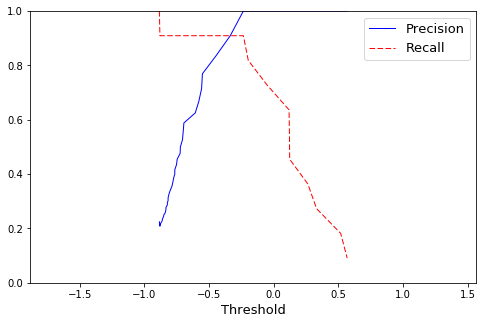

In [16]:
svc_scoreY = svc_clf.decision_function(testX)
plot_precision_recall_tradeoff(svc_scoreY)

As seen in the above plot, if the threshold value is set near $-0.3$, we get _maximum precision without losing recall_.

In [17]:
predictedY = (svc_scoreY > -0.3)
print_scores(predictedY)

Precision: 1.0
Recall: 0.9090909090909091
F1: 0.9523809523809523
Confusion matrix:
[[173   0]
 [  1  10]]


As observed in above data, the accuracy of Linear SVC classifier has reached its maximum while the recall is optimal.

### Stochastic Gradient Descent Classifier

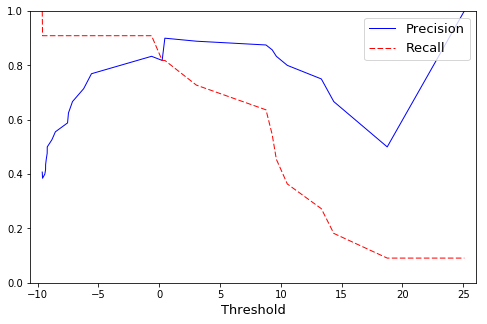

In [18]:
sgd_scoreY = sgd_clf.decision_function(testX)
plot_precision_recall_tradeoff(sgd_scoreY)

As seen in the above plot, if the threshold value is set near $0.3$, we get _maximum precision without losing recall_.

In [19]:
predictedY = (sgd_scoreY > 0.3)
print_scores(predictedY)

Precision: 0.9
Recall: 0.8181818181818182
F1: 0.8571428571428572
Confusion matrix:
[[172   1]
 [  2   9]]


As observed in above data, the accuracy of SGD classifier couldn't be any higher for any value of _threshold_ in the given range, without losing recall.

## Conclusion

__Linear Support Vector Classifier__ performed better than all four classifiers chosen in the above analysis.

__Various scores achieved:__
1. __Precision__: $1.0$
2. __Recall__: $0.91$
3. __F1 Score__: $0.95$
4. __Confusion Matrix__: $\quad \begin{bmatrix} 173 & 0 \\ 1 & 10 \end{bmatrix} \quad$

### Sources

1. hackernoon.com (https://hackernoon.com/how-to-build-a-simple-spam-detecting-machine-learning-classifier-4471fe6b816e)
2. Scikit Learn official documentation (http://scikit-learn.org/stable/documentation.html)
3. Wikipedia - Binary classification (https://en.wikipedia.org/wiki/Binary_classification))
4. Hands on Machine Learning notes (https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)
5. matplotlib Pyplot documentation (https://matplotlib.org/users/pyplot_tutorial.html)
6. pandas documentation (https://pandas.pydata.org/pandas-docs/stable/)